# 1. Load Dataset

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# URL dataset
train_url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/04.%20Week%204/Datasets/FeatureEngineering/train.csv"
test_url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/04.%20Week%204/Datasets/FeatureEngineering/test.csv"

# Memuat data
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)


# 2. Exploratory Data Analysis (EDA)

Dimensi Data Latih: (1460, 81)

Missing Values pada Data Latih:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64


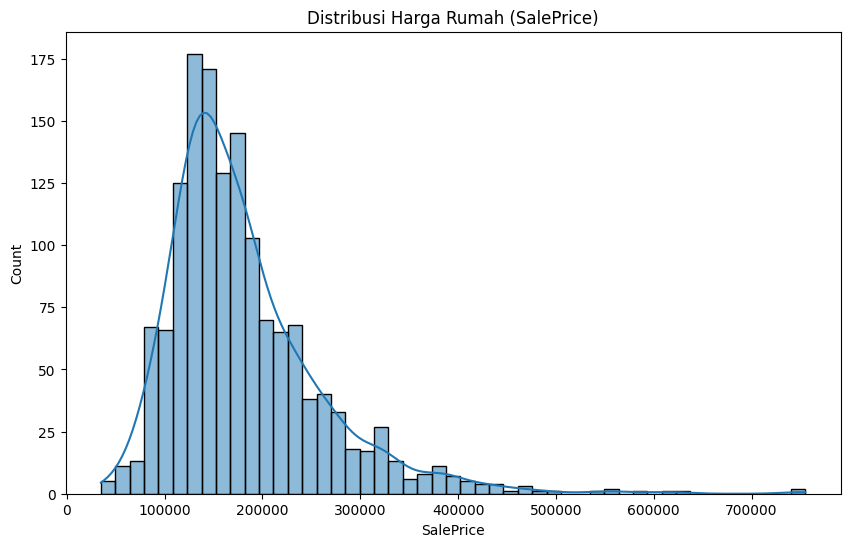

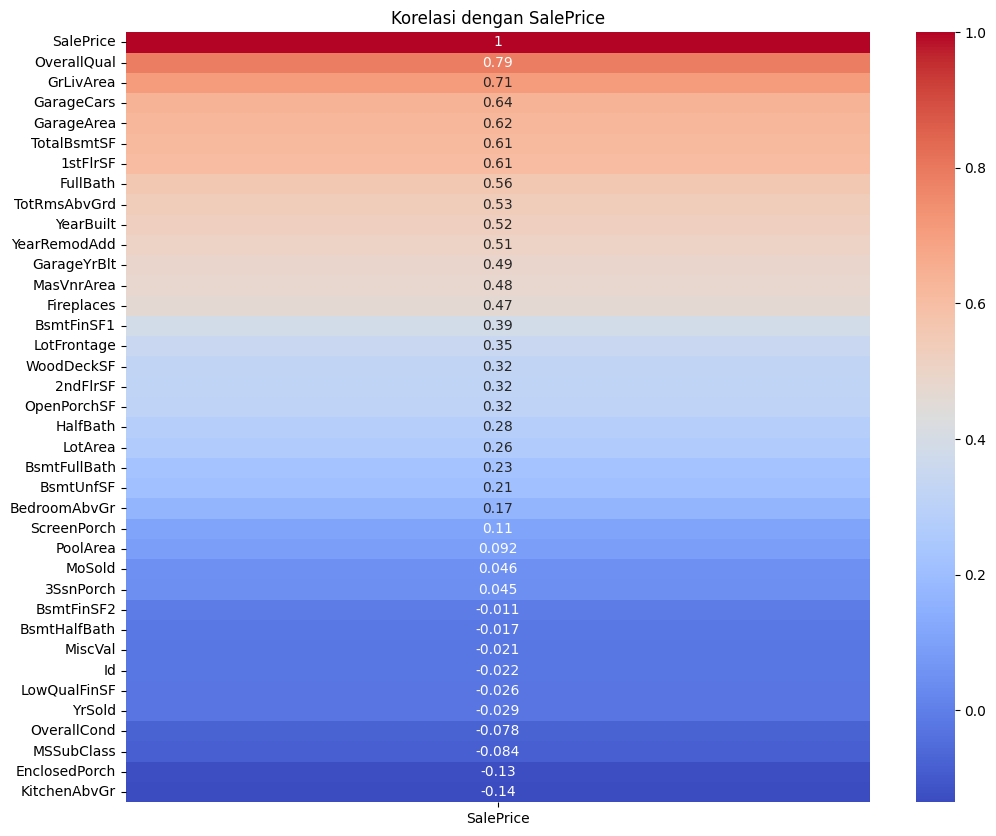

In [2]:
# Menampilkan informasi dataset
print("Dimensi Data Latih:", train_df.shape)
print("\nMissing Values pada Data Latih:")
print(train_df.isnull().sum().sort_values(ascending=False).head(10))

# Visualisasi distribusi target
plt.figure(figsize=(10,6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribusi Harga Rumah (SalePrice)')
plt.show()

# Korelasi numerik
corr_matrix = train_df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Korelasi dengan SalePrice')
plt.show()


# 3. Feature Engineering

In [3]:
# Pisahkan fitur dan target
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Split data menjadi training dan validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifikasi kolom numerik dan kategorikal
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include='object').columns

# Pipeline untuk preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)])


# 4. Model Training dan Evaluasi

In [4]:
# Inisialisasi model regresi linier
model = LinearRegression()

# Membuat pipeline dengan preprocessing dan model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# Melatih model
clf.fit(X_train, y_train)

# Fungsi evaluasi model
def evaluate_model(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, preds)
    return mse, rmse, r2

# Evaluasi pada data training dan validasi
train_mse, train_rmse, train_r2 = evaluate_model(clf, X_train, y_train)
val_mse, val_rmse, val_r2 = evaluate_model(clf, X_val, y_val)

# Menampilkan hasil evaluasi
print(f"""
Metrik Training:
MSE: {train_mse:.2f}
RMSE: {train_rmse:.2f}
R²: {train_r2:.4f}

Metrik Validasi:
MSE: {val_mse:.2f}
RMSE: {val_rmse:.2f}
R²: {val_r2:.4f}
""")



Metrik Training:
MSE: 381383632.07
RMSE: 19529.05
R²: 0.9361

Metrik Validasi:
MSE: 868845459.54
RMSE: 29476.18
R²: 0.8867



# 5. Perhitungan Overfitting

In [5]:
# Menghitung selisih performa
gap_rmse = (val_rmse - train_rmse) / train_rmse
gap_r2 = train_r2 - val_r2

# Menampilkan analisis overfitting
print(f"Gap RMSE: {gap_rmse:.2%}")
print(f"Gap R²: {gap_r2:.4f}")

if gap_rmse > 0.1 or gap_r2 > 0.1:
    print("\n⚠️ Model menunjukkan overfitting!")
elif gap_rmse > 0.05 or gap_r2 > 0.05:
    print("\n⚠️ Model mulai overfitting!")
else:
    print("\nModel tidak overfitting.")


Gap RMSE: 50.94%
Gap R²: 0.0493

⚠️ Model menunjukkan overfitting!


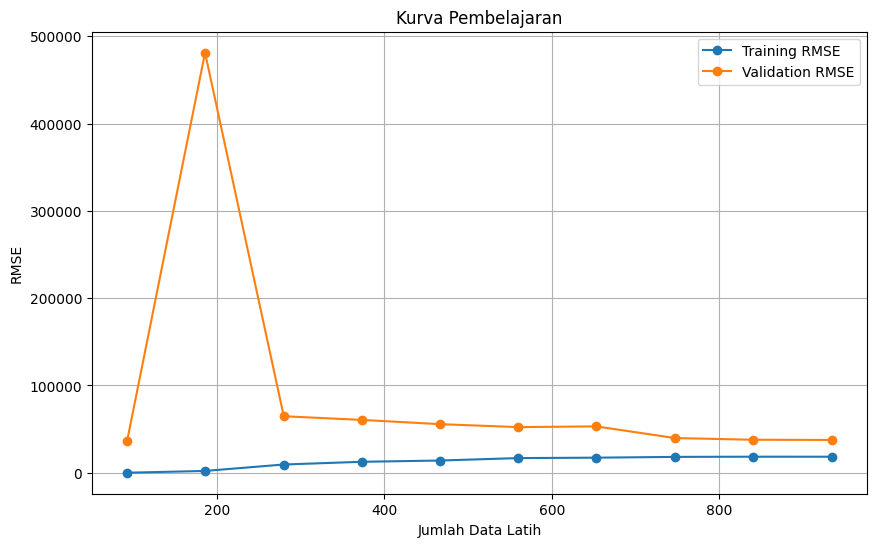

In [7]:
from sklearn.model_selection import learning_curve

# Menghasilkan kurva pembelajaran
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Plot kurva pembelajaran
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training RMSE')
plt.plot(train_sizes, -val_scores.mean(axis=1), 'o-', label='Validation RMSE')
plt.xlabel("Jumlah Data Latih")
plt.ylabel("RMSE")
plt.legend()
plt.title("Kurva Pembelajaran")
plt.grid(True)
plt.show()


# Penjelasan Persamaan Matematika

## Mean Squared Error (MSE)

Rumus MSE:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

**Penjelasan:**  
MSE mengukur rata-rata dari kuadrat selisih antara nilai aktual $(y_i)$ dan nilai prediksi $(\hat{y}_i)$.  
Nilai MSE yang lebih kecil menunjukkan bahwa model memprediksi nilai yang lebih mendekati nilai aktual.



## Root Mean Squared Error (RMSE)

Rumus RMSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

**Penjelasan:**  
RMSE adalah akar kuadrat dari MSE.  
RMSE memberikan ukuran error dalam satuan yang sama dengan target, sehingga memudahkan interpretasi performa model.



## Coefficient of Determination (R²)

Rumus R²:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

**Penjelasan:**  
- $(y_i):$ Nilai aktual  
- $(\hat{y}_i):$ Nilai prediksi oleh model  
- $(\bar{y}):$ Rata-rata nilai aktual  
- $(n):$ Jumlah data

R² mengukur proporsi variansi dalam target yang dapat dijelaskan oleh fitur dalam model.  
Nilai R² berkisar antara 0 hingga 1. Nilai yang mendekati 1 menunjukkan bahwa model mampu menjelaskan variansi data dengan baik, sedangkan nilai yang mendekati 0 menunjukkan sebaliknya.



## Deteksi Overfitting

Jika performa model pada data training jauh lebih baik daripada pada data testing (misalnya, R² training tinggi dan R² testing rendah, atau RMSE testing jauh lebih besar daripada RMSE training), hal ini dapat mengindikasikan bahwa model mengalami **overfitting**.  
Overfitting terjadi ketika model terlalu kompleks dan "mempelajari" noise dari data training sehingga performanya menurun saat diuji pada data baru.
